In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_training_log = pd.read_csv("./kaggle_trainning.log")
df_training_log.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.039583,6.560125,0.041667,13.388053
1,1,0.077083,5.382832,0.062500,10.201756
2,2,0.116129,4.489160,0.145833,6.837718
3,3,0.141667,3.897532,0.177083,4.819786
4,4,0.187500,3.557507,0.177083,4.459396


In [3]:
df_train = df_training_log[["epoch","accuracy", "loss"]]
df_train["type"] = "train"
df_val = df_training_log[["epoch", "val_accuracy", "val_loss"]]
df_val =df_val.rename(columns={"val_accuracy":"accuracy", "val_loss":"loss"})
df_val["type"] = "val"
df = pd.concat([df_train, df_val])

/home/sc82choi/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


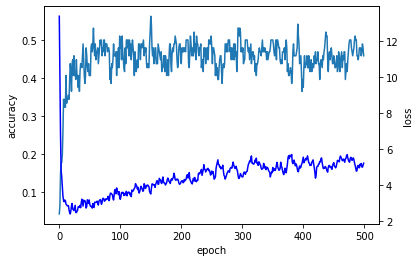

In [4]:
val_features = ["val_accuracy", "val_loss"]
ax = sns.lineplot(x="epoch", y="accuracy", data=df[df["type"] == "val"])
ax2 = plt.twinx()
sns.lineplot(x="epoch", y="loss", data=df[df["type"] == "val"], color="b", ax=ax2)
plt.show()

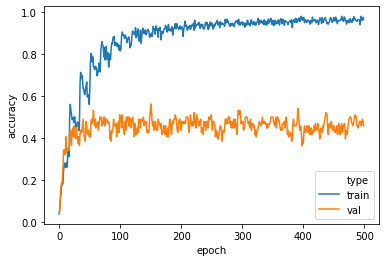

In [5]:
acc_features = ["val_accuracy", "accuracy"]
sns.lineplot(x="epoch", y="accuracy", data=df, hue="type")
plt.show()

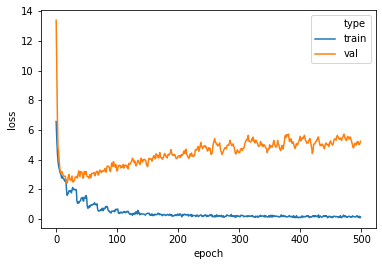

In [6]:
sns.lineplot(x="epoch", y="loss", data=df, hue="type")
plt.show()

In [7]:
df[df["type"] == "val"].sort_values(["loss","accuracy"]).head()

,epoch,accuracy,loss,type
18,18,0.437500,2.415481,val
17,17,0.395833,2.489636,val
28,28,0.447917,2.491147,val
27,27,0.395833,2.498861,val
29,29,0.406250,2.564680,val


In [8]:
df[df["type"] == "val"].sort_values(["accuracy","loss"], ascending=False).head()

,epoch,accuracy,loss,type
150,150,0.562500,3.522593,val
391,391,0.541667,4.776292,val
151,151,0.541667,3.830348,val
293,293,0.531250,4.565685,val
296,296,0.531250,4.520573,val


In [9]:
import os
CHECKPOINT_DIR = "./checkpoints"
checkpoint_files = sorted([filename for filename in os.listdir(CHECKPOINT_DIR) if "KAGGLE_ONLY" in filename ])

In [10]:
checkpoint_files[150]

'model-VGG16_optimizer-adam_dataset-KAGGLE_ONLY_151_0.56_3.52.hdf5'

In [11]:
checkpoint_files[18]


'model-VGG16_optimizer-adam_dataset-KAGGLE_ONLY_019_0.44_2.42.hdf5'

In [1]:
from model import VGG16ForDogBreed

In [ ]:
model = VGG16ForDogBreed(input_shape=(224,224,3))